In [1]:
import os
import sys
parent = os.path.realpath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(parent)
import numpy as np
from databases.sql_connect import create_connection
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

conn = None
sns.set_theme()
sns.set(context="paper", style="darkgrid", font="Times New Roman")
cm = 1/2.54
DB_CORR = os.path.join(parent,"databases", "TEMPRO_DB230416_Corr.db")
assert(os.path.exists(DB_CORR))
FONTSIZE = 8

symbols = {"output aluminium scrap, post-consumer, prepared for melting": "Al",
           "Dysprosium": "REE",
           "output iron scrap, sorted, pressed": "Fe",
           "Neodymium": "Nd",
           "Tantalum": "Ta",
           "Yttrium": "REE",
           "Gold": "PM",
           "Silver": "PM",
           "Palladium": "PM",
           "output copper scrap, sorted, pressed": "Cu",
           "PCB Pyrolysis": "Recyc.",
           "PCB HM": "Recyc.",
           "PCB ER": "Recyc.",
           "PCB Bioleech": "Recyc.",
           "Tantal Recycling": "Recyc."}


C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_40652\2060946824.py:15: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [2]:
#get ced impacts per material

    #fetch the results of the sql DB
def get_recovery_impacts(ps_id,method,cmap,impact="CED - total"):

    ps_id=str(ps_id)
    conn = create_connection(DB_CORR)

    queryLCA_1000 = f'SELECT * FROM [1000LCAResults]'
    lca = pd.read_sql_query(queryLCA_1000, conn)
    lca_ced1 = lca[lca["Category"]==impact]
    lca_ced1.set_index("ProductSystemID", inplace=True)


    # query for scraps
    queryLCA_2000 = f'SELECT * FROM [2000LCAResults]'
    lca2 = pd.read_sql_query(queryLCA_2000, conn)
    lca_ced2 = lca2[lca2["Category"]=="CED - total"]
    lca_ced2 = lca_ced2[lca_ced2["ProductSystemID"]>2900]
    lca_ced2.set_index("ProductSystemID", inplace=True)


    #get ced data for the recycling process
    queryLCA_8000 = f'SELECT * FROM [8000LCAResults]'
    lca8 = pd.read_sql_query(queryLCA_8000, conn)
    lca_ced8 = lca8[lca8["Category"]=="CED - total"]
    lca_ced8.set_index("ProductSystemID", inplace=True)


    # get inventories for the part ID = 3208 and for the method
    query_recy=f'SELECT * FROM [9000Exchanges]' 
    exc9= pd.read_sql_query(query_recy, conn)

    exc9= exc9[exc9["9000Name"].str.contains(ps_id)==True] 
    exc9= exc9[exc9["9000Name"].str.contains(method)==True]
    exc9= exc9[['9000ID', '9000Name', '1000Materials', '2000Parts',
        '8000Recycling', 'ExchangeName','Amount']]
    exc9["CED_PS"]=np.nan
    exc9["Symbol"]=np.nan
    for idx in exc9.index:
        if exc9.at[idx, "1000Materials"]>1000:
            mat= exc9.at[idx, "1000Materials"]
            exc9.at[idx, "CED_PS"]=lca_ced1.at[mat,"Result"]

        if exc9.at[idx, "2000Parts"]>2000:
            mat= exc9.at[idx, "2000Parts"]
            exc9.at[idx, "CED_PS"]=lca_ced2.at[mat,"Result"]

        if exc9.at[idx, "8000Recycling"]>8000:
            mat= exc9.at[idx, "8000Recycling"]
            exc9.at[idx, "CED_PS"]=lca_ced8.at[mat,"Result"]
        
        exc9.at[idx, "Symbol"]=symbols[exc9.at[idx,"ExchangeName"]]

    exc9["Contrib"]=exc9["Amount"]*exc9["CED_PS"]
    exc9_res = exc9[["Symbol","Contrib"]]      
    exc9_res=exc9_res.groupby("Symbol").sum()
    exc9_res=exc9_res.sort_values("Contrib", ascending=False)
    base =[0]
    for x in exc9_res["Contrib"][0:-1]:
        b = x+base[-1]
        base.append(b)
    exc9_res["Base"]=base


    cmap = matplotlib.cm.get_cmap(cmap)
    max_recovery = min([x for x in exc9_res["Contrib"] if x<0])
    exc9_res["Color"] = "blue"
    for idx in exc9_res.index:
        if exc9_res.at[idx,"Contrib"]<0:
            proportion = exc9_res.at[idx,"Contrib"]/max_recovery
            proportion = 0.5+0.5#*proportion
            color = cmap(proportion)
            exc9_res.at[idx,"Color"]=matplotlib.colors.to_hex(color, keep_alpha=True)

    return exc9_res


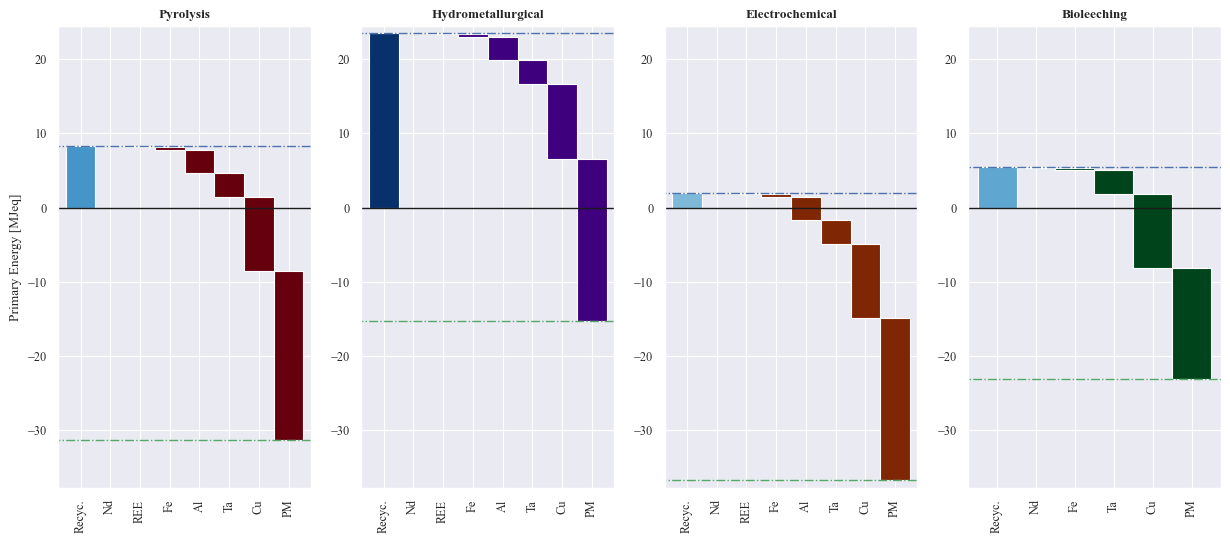

In [3]:
ps_id=3208
fig,axs=plt.subplots(1,4, figsize=(15,6))
i=0
top=[]
bottom=[]
dfs=[]
impact="CED - total"
colormaps= ["Reds", "Purples", "Oranges","Greens"]
methods= ["pyrolysis", "HM", "ER", "bioleeching"]
titles={"pyrolysis":"Pyrolysis", "HM":"Hydrometallurgical" , "ER": "Electrochemical" , "bioleeching":"Bioleeching"}

for i in range(0,4):
    exc9_res=get_recovery_impacts(ps_id=ps_id,method=methods[i],cmap=colormaps[i])
    total = exc9_res["Contrib"].sum()
    dfs.append(exc9_res)
    top.append(max(exc9_res["Base"]))
    bottom.append(total)

cmap = matplotlib.cm.get_cmap("Blues")

for i in range(0,4):
    ax=axs[i]
    exc9_res= dfs[i]
    proportion = top[i]/max(top)
    proportion = 0.4+0.6*proportion
    color = cmap(proportion)
    exc9_res.at["Recyc.","Color"]=matplotlib.colors.to_hex(color, keep_alpha=True)

    exc9_res["Contrib"].plot(kind = "bar",bottom = exc9_res["Base"],width = 1, color = exc9_res["Color"], ax=ax)
    ax.set_title(titles[methods[i]], fontweight='bold')
    ax.plot([-1, 9], [0, 0], "k",linewidth=1) 
    ax.plot([-1, 9], [bottom[i], bottom[i]], "g-.",linewidth=1)
    ax.plot([-1, 9], [top[i], top[i]], "b-.",linewidth=1)
    ax.set_xlabel("") 
    if i ==0:
        ax.set_ylabel("Primary Energy [MJeq]") 

for ax in axs:
    ax.set_ylim(min(bottom)-1,max(top)+1)

#fig.savefig(f"RecoveryComparison/RecyComp_{ps_id}_{impact}.jpg")

#make a cascate graph

In [4]:
def get_ps_info(group= 4000):
    conn = create_connection(DB_CORR)
    table_name = {2000:"2000Parts",
                  3000:"3000Pieces",
                  4000:"4000Devices",
                5000:"5000Systems",
                                6000:"6000DataCenters"}
    query = f'SELECT * FROM [{table_name[group]}]'
    df_ps = pd.read_sql_query(query, conn)
    conn.close() 
    df_ps.set_index("ID", inplace=True)
    return df_ps

In [5]:
cats = {"EI-Minerals- Total": "ADP-EI",
        #"GPR-Minerals- Total": "GPSR",
        "CED - total": "CED",
        "CExD - metals": "CExD",
        "ReCiPe Midpoint (E) - metal depletion (MDP)": "MDP",
        "ADP-Minerals- Total": "ADP",
        "ReCiPe Endpoint (E - A) - total (total)": "Total",
        "CML-climate change (GWP 100a)": "GWP"}

full_label= {'ADP-EI': 'ADP - Economic Importance [kg Sb-eq]',
 'GPSR': 'Geo-Political Suppy Risk [1]',
 'CED': 'Primary Energy Demand [MJ-eq]',
 'CExD': 'Primary Exergy Demand [MJ-eq]',
 'MDP': 'Metal Depletion Potential [kg Fe-eq]',
 'ADP': 'Abiotic Depletion Potential [kg Sb-eq]',
 'Total': 'ReCiPe-Total Impacts',
 'GWP': 'Greenhouse Emissions [kg CO2-eq]'}

In [9]:
def create_graph_recovery_comp(ps_id=3208, impact = "CML-climate change (GWP 100a)"):
    try:    
        fig,axs=plt.subplots(1,4, figsize=(15,5))
        i=0
        top=[]
        bottom=[]
        dfs=[]
        colormaps= ["Reds", "Purples", "Oranges","Greens"]
        methods= ["pyrolysis", "HM", "ER", "bioleeching"]
        titles={"pyrolysis":"Pyrolysis", "HM":"Hydrometallurgical" , "ER": "Electrochemical" , "bioleeching":"Bioleeching"}

        for i in range(0,4):

            exc9_res=get_recovery_impacts(ps_id=ps_id,method=methods[i],cmap=colormaps[i], impact=impact)
            total = exc9_res["Contrib"].sum()
            dfs.append(exc9_res)
            top.append(max(exc9_res["Base"]))
            bottom.append(total)


        cmap = matplotlib.cm.get_cmap("Blues")

        for i in range(0,4):
            ax=axs[i]
            exc9_res= dfs[i]
            proportion = top[i]/max(top)
            proportion = 0.2+0.8*proportion
            color = cmap(proportion)
            exc9_res.at["Recyc.","Color"]=matplotlib.colors.to_hex(color, keep_alpha=True)

            exc9_res["Contrib"].plot(kind = "bar",bottom = exc9_res["Base"],width = 1, color = exc9_res["Color"], ax=ax)
            ax.set_title(titles[methods[i]], fontweight='bold')
            ax.plot([-1, 9], [0, 0], "k",linewidth=1) 
            ax.plot([-1, 9], [bottom[i], bottom[i]], "g-.",linewidth=1)
            ax.plot([-1, 9], [top[i], top[i]], "b-.",linewidth=1)
            ax.set_xlabel("") 
            if i ==0:
                #ax.set_ylabel("Primary Energy\nIntensity [MJ-eq/kg]") 
                ax.set_ylabel(full_label[cats[impact]]) 
        for ax in axs:
            ax.set_ylim(min(bottom)-1,max(top)+1)

        df_3000_info = get_ps_info(3000)

        title = df_3000_info.at[ps_id, "Name"]

        fig.suptitle(f"Recovery LCIA for {title}",fontsize = FONTSIZE*1.5, fontweight="bold" )
        fig.tight_layout()
        fig.savefig(f"RecoveryComparison/RecComp-{ps_id}-{impact}.png", dpi=600, bbox_inches='tight', )
        plt.close()
    except Exception as e:
        print(e)
        print(f"Could not work for ps {ps_id}")
        pass


In [10]:
for i in [3214, 3202, 3208,3218]:
    for impact in cats.keys():
        create_graph_recovery_comp(i, impact)